

# You may copy and edit as much as you want.
# Upvote this notebook which encourage me to make more such notebooks. Thanks


# Basics:
In this notebook, you will learn about 3D MRI brain tumor segmentation using U-net.
Here is the step by step process.

Please follow the comments for better understanding.Everything is explained in the  comments.




If the notebook helpful to you pls Upvote me .which will encourage me creating more notebooks like that to help you.
Thanks You!

# What is 3D image in MRI?

Usually the images are 2-dimensional, where the MRI images are usually presented in slices from top to bottom. However, using sophisticated computer calculation, these 2-dimensional slices can be joined together to produce a 3-dimensional model of the area of interest being scanned. This is called 3D MRI.
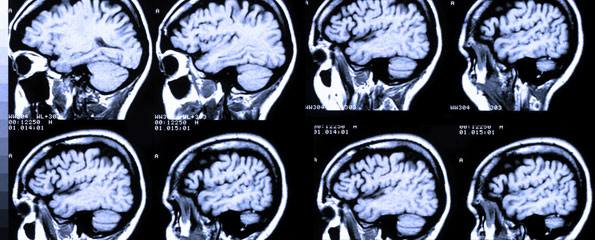

# Install the required library :

In [1]:

import numpy as np
import nibabel as nib
import glob
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Load the data  and undersatnd the data

In [2]:

TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_051/BraTS20_Training_051_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_051/BraTS20_Training_051_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_051/BraTS20_Training_051_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_051/BraTS20_Training_051_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_051/BraTS20_Training_051_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 


827.0
[0 1 2 4]
[0 1 2 3]


In [3]:
test_mask.shape

(240, 240, 155)

# Visualize the image slices and mask

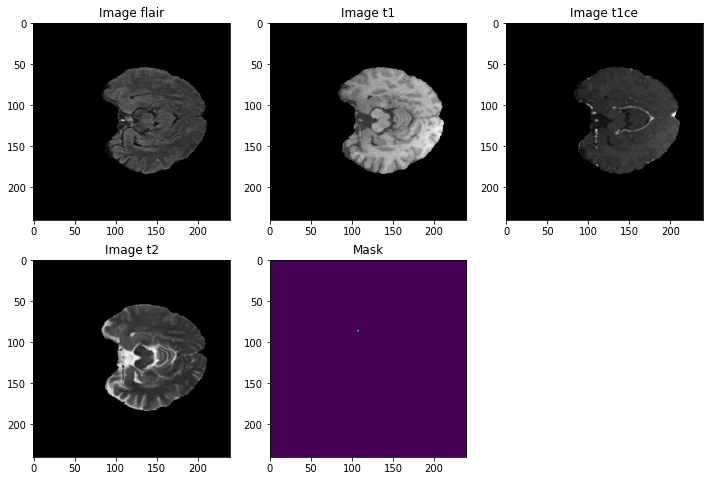

In [4]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# 3D MRI image
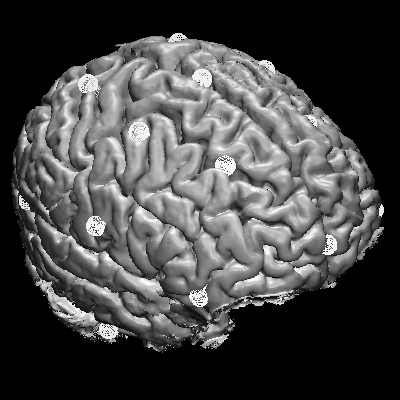

# Combining :

Flair, T1CE, annd T2 have the most information
Combine t1ce, t2, and flair into single multichannel image

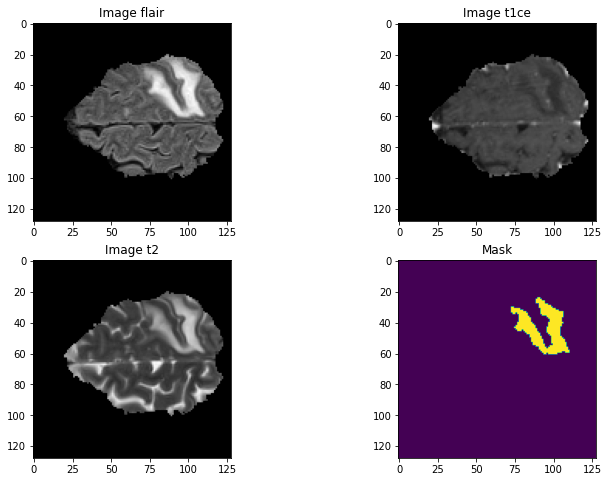

In [5]:


combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [6]:
os.mkdir('/kaggle/working/BraTS2020_TrainingData/')



# save the combined image

In [7]:
imsave('BraTS2020_TrainingData/combined255.tif', combined_x)
np.save('BraTS2020_TrainingData/combined255.npy', combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load('BraTS2020_TrainingData/combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)

# End of understanding the dataset. Now get it organized

#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d

# images lists harley

In [8]:
from pathlib import Path
TMP_DIR = Path('../temp')
TMP_DIR.mkdir(exist_ok=True)

In [9]:
os.mkdir('/kaggle/temp/BraTS2020_TrainingData/')

In [10]:
ls ../temp/BraTS2020_TrainingData/

In [11]:
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t1ce_list = sorted(glob.glob('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [12]:
print(t2_list.pop(354))
print(t1ce_list.pop(354))
print(flair_list.pop(354))

../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1.nii
../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1ce.nii
../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii


#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

In [13]:
len(t2_list)

368

# Create the output directory

In [14]:
os.mkdir('/kaggle/temp/BraTS2020_TrainingData/input_data_3channels')
os.mkdir('/kaggle/temp/BraTS2020_TrainingData/input_data_3channels/masks')
os.mkdir('/kaggle/temp/BraTS2020_TrainingData/input_data_3channels/images/')

# Now preparing image and masks

In [15]:
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('/kaggle/temp/BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('/kaggle/temp/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
        
    else:
        print("I am useless")  
        print("I am useless")   

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19


In [16]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


# Splitting the data

In [17]:

import splitfolders  # or import split_folders

input_folder = '/kaggle/temp/BraTS2020_TrainingData/input_data_3channels/'
output_folder = '/kaggle/temp/BraTS2020_TrainingData/input_data_128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values


Copying files: 686 files [02:47,  4.10 files/s]


In [18]:
import shutil
shutil.rmtree("/kaggle/temp/BraTS2020_TrainingData/input_data_3channels/")

"""
Custom data generator to work with BraTS2020 dataset.
Can be used as a template to create your own custom data generators. 
No image processing operations are performed here, just load data from local directory
in batches. 
"""

#from tifffile import imsave, imread

In [19]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)


In [20]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


In [21]:
#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "/kaggle/temp/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/kaggle/temp/BraTS2020_TrainingData/input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)
train_img_list.sort()
train_mask_list.sort()

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)


In [22]:
for i in range(len(train_img_list)):
    print(train_img_list[i]+" Mask :" +train_mask_list[i])
    

image_0.npy Mask :mask_0.npy
image_1.npy Mask :mask_1.npy
image_10.npy Mask :mask_10.npy
image_101.npy Mask :mask_101.npy
image_102.npy Mask :mask_102.npy
image_103.npy Mask :mask_103.npy
image_104.npy Mask :mask_104.npy
image_105.npy Mask :mask_105.npy
image_106.npy Mask :mask_106.npy
image_108.npy Mask :mask_108.npy
image_11.npy Mask :mask_11.npy
image_112.npy Mask :mask_112.npy
image_115.npy Mask :mask_115.npy
image_116.npy Mask :mask_116.npy
image_117.npy Mask :mask_117.npy
image_118.npy Mask :mask_118.npy
image_119.npy Mask :mask_119.npy
image_122.npy Mask :mask_122.npy
image_123.npy Mask :mask_123.npy
image_124.npy Mask :mask_124.npy
image_125.npy Mask :mask_125.npy
image_127.npy Mask :mask_127.npy
image_128.npy Mask :mask_128.npy
image_129.npy Mask :mask_129.npy
image_13.npy Mask :mask_13.npy
image_131.npy Mask :mask_131.npy
image_134.npy Mask :mask_134.npy
image_135.npy Mask :mask_135.npy
image_136.npy Mask :mask_136.npy
image_139.npy Mask :mask_139.npy
image_14.npy Mask :mask_

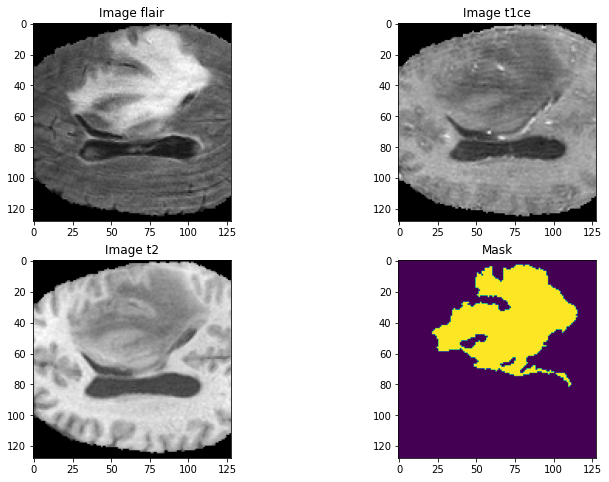

In [23]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Code to train batches of cropped BraTS 2020 images using 3D U-net.
Please get the data ready and define custom data gnerator using the other
files in this directory.
Images are expected to be 128x128x128x3 npy data (3 corresponds to the 3 channels for 
                                                  test_image_flair, test_image_t1ce, test_image_t2)
Change the U-net input shape based on your input dataset shape (e.g. if you decide to only se 2 channels or all 4 channels)
Masks are expected to be 128x128x128x3 npy data (4 corresponds to the 4 classes / labels)
You can change input image sizes to customize for your computing resources.
"""



In [24]:
pip install imageloader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 234.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for imageloader: filename=imageloader-0.0.5-cp37-cp37m-linux_x86_64.whl size=241065 sha256=b323ea757de28a1e673d55d2bfb02b9bf66b78e8b13cdfd73d2490d72d89fbd3
  Stored in directory: /root/.cache/pip/wheels/a6/68/cd/c4c3af766c7806f6b6d304b8b00fc6afcc425b2aec7d86cf1c
Successfully built imageloader
Note: you may need to restart the kernel to use updated packages.


In [25]:

import os
import numpy as np
#import imageloader
#from custom_datagen import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

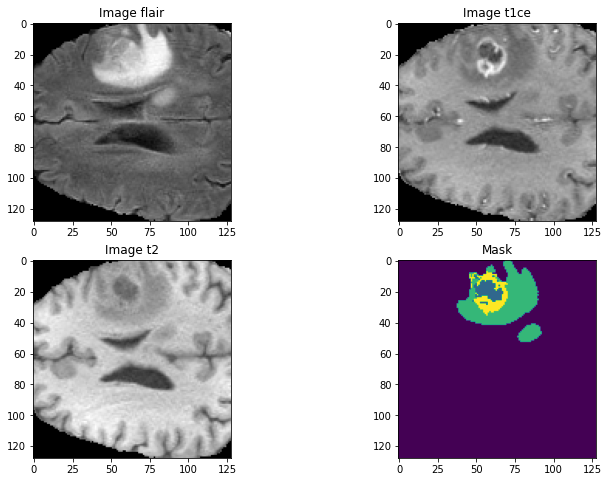

In [26]:
train_img_dir = "/kaggle/temp/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/kaggle/temp/BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)
img_list.sort()
msk_list.sort()

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [27]:
for i in range(len(img_list)):
    print(img_list[i]+" Mask :" +msk_list[i])

image_0.npy Mask :mask_0.npy
image_1.npy Mask :mask_1.npy
image_10.npy Mask :mask_10.npy
image_101.npy Mask :mask_101.npy
image_102.npy Mask :mask_102.npy
image_103.npy Mask :mask_103.npy
image_104.npy Mask :mask_104.npy
image_105.npy Mask :mask_105.npy
image_106.npy Mask :mask_106.npy
image_108.npy Mask :mask_108.npy
image_11.npy Mask :mask_11.npy
image_112.npy Mask :mask_112.npy
image_115.npy Mask :mask_115.npy
image_116.npy Mask :mask_116.npy
image_117.npy Mask :mask_117.npy
image_118.npy Mask :mask_118.npy
image_119.npy Mask :mask_119.npy
image_122.npy Mask :mask_122.npy
image_123.npy Mask :mask_123.npy
image_124.npy Mask :mask_124.npy
image_125.npy Mask :mask_125.npy
image_127.npy Mask :mask_127.npy
image_128.npy Mask :mask_128.npy
image_129.npy Mask :mask_129.npy
image_13.npy Mask :mask_13.npy
image_131.npy Mask :mask_131.npy
image_134.npy Mask :mask_134.npy
image_135.npy Mask :mask_135.npy
image_136.npy Mask :mask_136.npy
image_139.npy Mask :mask_139.npy
image_14.npy Mask :mask_

In [28]:
#Define the image generators for training and validation

train_img_dir = "/kaggle/temp/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/kaggle/temp/BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "/kaggle/temp/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "/kaggle/temp/BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)
train_img_list.sort()
train_mask_list.sort()
val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
val_img_list.sort()
val_mask_list.sort()

In [29]:
for i in range(len(train_img_list)):
    print(train_img_list[i]+" Mask :" +train_mask_list[i])
    
print("Validation")

for i in range(len(val_img_list)):
    print(val_img_list[i]+" Mask :" +val_mask_list[i])

image_0.npy Mask :mask_0.npy
image_1.npy Mask :mask_1.npy
image_10.npy Mask :mask_10.npy
image_101.npy Mask :mask_101.npy
image_102.npy Mask :mask_102.npy
image_103.npy Mask :mask_103.npy
image_104.npy Mask :mask_104.npy
image_105.npy Mask :mask_105.npy
image_106.npy Mask :mask_106.npy
image_108.npy Mask :mask_108.npy
image_11.npy Mask :mask_11.npy
image_112.npy Mask :mask_112.npy
image_115.npy Mask :mask_115.npy
image_116.npy Mask :mask_116.npy
image_117.npy Mask :mask_117.npy
image_118.npy Mask :mask_118.npy
image_119.npy Mask :mask_119.npy
image_122.npy Mask :mask_122.npy
image_123.npy Mask :mask_123.npy
image_124.npy Mask :mask_124.npy
image_125.npy Mask :mask_125.npy
image_127.npy Mask :mask_127.npy
image_128.npy Mask :mask_128.npy
image_129.npy Mask :mask_129.npy
image_13.npy Mask :mask_13.npy
image_131.npy Mask :mask_131.npy
image_134.npy Mask :mask_134.npy
image_135.npy Mask :mask_135.npy
image_136.npy Mask :mask_136.npy
image_139.npy Mask :mask_139.npy
image_14.npy Mask :mask_

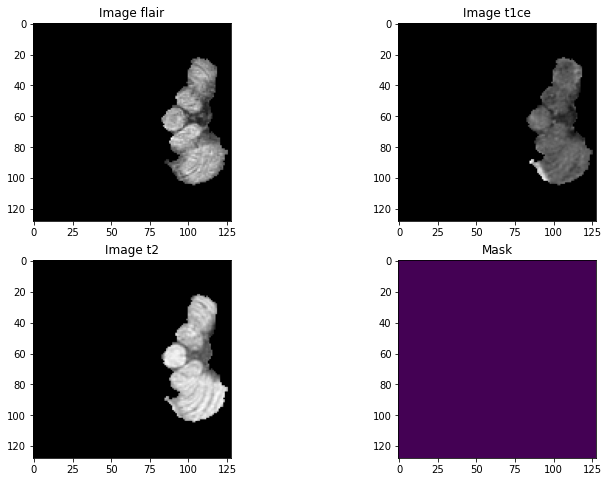

In [30]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Let's understand the 3D U-net architecture
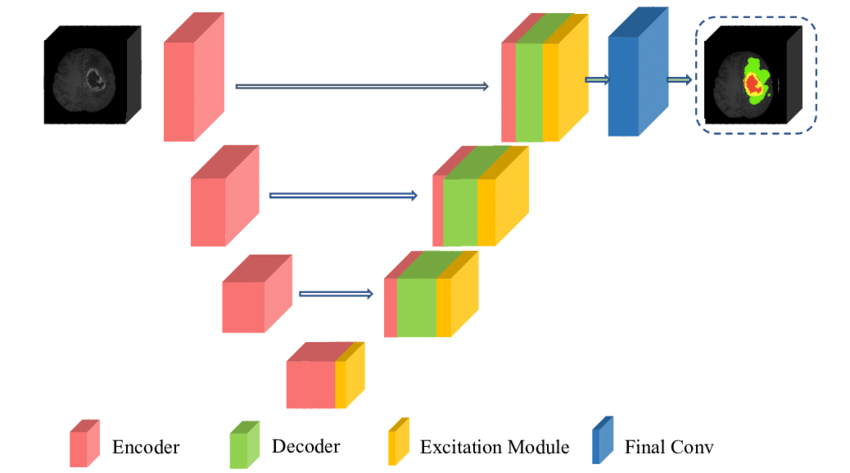

# How does 3D U-net works?

3D-UNet is composed of a contractive and an expanding path, that aims at building a bottleneck in its centermost part through a combination of convolution and pooling operations. After this bottleneck, the image is reconstructed through a combination of convolutions and upsampling.

# Creatiing 3D U-net Model

As our mri image is 3D image. so for 3D segmentation we require 3D U-net model. we just take "Conv3D, MaxPooling3D Conv3DTranspose" instead of Conv2D, MaxPooling2D Conv2DTranspose. Thus 2D U-net architecture will convert into 3D U-net

In [31]:


from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam

from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 1312        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 128 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 6928        dropout[0][0]                    
______________________________________________________________________________________________

In [32]:
pip install segmentation-models-3d --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.5/497.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 294.2 kB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning,

In [33]:
#Define loss, metrics and optimizer to be used for training
from tensorflow.keras.optimizers import Adam
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim =Adam(LR)


Segmentation Models: using `tf.keras` framework.


In [34]:
pip install plotly==5.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 6.0 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.10.0
    Uninstalling plotly-5.10.0:
      Successfully uninstalled plotly-5.10.0
Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install ctranslate2==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 61.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install OpenNMT-tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: ctranslate2
    Found existing installation: ctranslate2 2.11.0
    Uninstalling ctranslate2-2.11.0:
      Successfully uninstalled ctranslate2-2.11.0
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.14.0
    Uninstalling tensorflow-addons-0.14.0:
      Successfully uninstalled tensorflow-addons-0.14.0
Note: you may need to restart the kernel to use updated packages.


In [37]:
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


#from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('brats_3d01-05-24.hdf5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_19 (Conv3D)              (None, 128, 128, 128 1312        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 128 0           conv3d_19[0][0]                  
__________________________________________________________________________________________________
conv3d_20 (Conv3D)              (None, 128, 128, 128 6928        dropout_9[0][0]                  
____________________________________________________________________________________________

# Visualize the output acc, loss

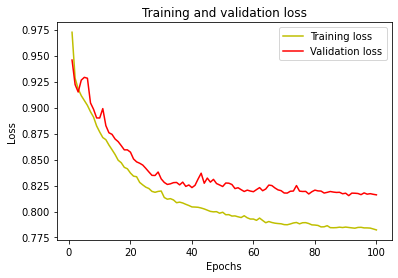

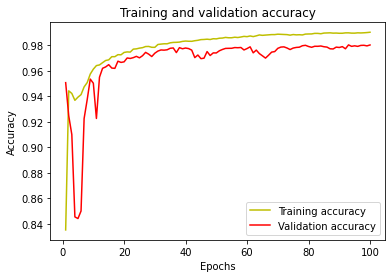

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Load the saved model

In [39]:
from keras.models import load_model



#Now, let us add the iou_score function we used during our initial training
my_model = load_model('brats_3d01-05-24.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process. 
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

128/128 [==============================] - 270s 2s/step - loss: 0.7821 - accuracy: 0.9906 - iou_score: 0.8075 - val_loss: 0.8159 - val_accuracy: 0.9796 - val_iou_score: 0.6682


In [40]:
#For predictions you do not need to compile the model, so ...
my_model = load_model('brats_3d01-05-24.hdf5', 
                      compile=False)


#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.83805984


Predict on a few test images, one at a time
#Try images: 

In [41]:
img_num = 82

test_img = np.load("/kaggle/temp/BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/kaggle/temp/BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))

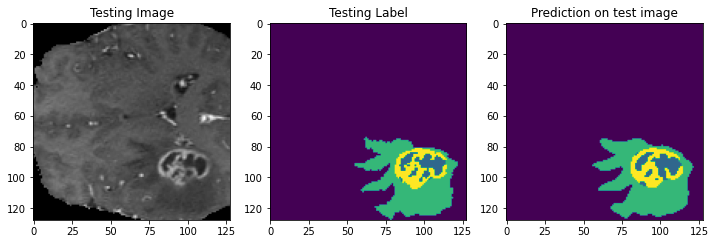

In [42]:
# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()


The END:

I think it useful for.
This notebook is created with help of Dr. Sreenivas Bhattiprolu contribution